In [59]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [89]:
from keras.models import Sequential, Model
from keras import layers
from keras.layers import Reshape, Activation, Conv2D, Input, MaxPooling2D, BatchNormalization, Flatten, Dense, Lambda,GlobalAveragePooling2D,Dropout
from keras.layers.advanced_activations import LeakyReLU
from keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard
from keras.optimizers import SGD, Adam, RMSprop
from keras.layers.merge import concatenate
import matplotlib.pyplot as plt
import keras.backend as K
import tensorflow as tf
import numpy as np
from keras import optimizers
from keras.applications.vgg16 import VGG16
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import cross_val_score, KFold
from google.colab import drive

xscale = 64/640
yscale = 64/480
X_train = np.load('/content/drive/My Drive/Updated_Data/Train_Processed_64.npy')
Y_train = np.load('/content/drive/My Drive/Updated_Data/Y_train.npy')
X_train = X_train.reshape(X_train.shape[0],X_train.shape[1],X_train.shape[2],1)
print(X_train.shape)
print(Y_train.shape)
Y_train_new = []
for i in range(0,Y_train.shape[0]):
    Y_train_new.append(Y_train[i][0])
Y_train_new = np.asarray(Y_train_new)
print(Y_train_new.shape)
print(Y_train_new.shape[0])
for i in range(0,Y_train_new.shape[0]):
    Y_train_new[i][0] = Y_train_new[i][0] * xscale
    Y_train_new[i][1] = Y_train_new[i][1] * xscale
    Y_train_new[i][2] = Y_train_new[i][2] * yscale
    Y_train_new[i][3] = Y_train_new[i][3] * yscale
X_train = X_train/255
mean = X_train.mean()
std = X_train.std()
print("Before ",mean,std)
X_train -= mean
X_train /= std
print("After ",X_train.mean(),X_train.std())


(14000, 64, 64, 1)
(14000, 1, 4)
(14000, 4)
14000
Before  0.6504078278186277 0.23190287922054598
After  -1.1470189877270188e-15 1.0000000000000018


In [0]:
input_1 = Input(shape = (64,64,1))
# Block 1
x = layers.Conv2D(64, (3, 3),
                  activation='relu',
                  padding='same',
                  name='block1_conv1')(input_1)
#x = Dropout(0.2)(x)
x = layers.Conv2D(64, (3, 3),
                  activation='relu',
                  padding='same',
                  name='block1_conv2')(x)
x = Dropout(0.2)(x)
x = layers.MaxPooling2D((2, 2), strides=(2, 2), name='block1_pool')(x)

# Block 2
x = layers.Conv2D(128, (3, 3),
                  activation='relu',
                  padding='same',
                  name='block2_conv1')(x)
#x = Dropout(0.2)(x)


x = layers.Conv2D(128, (3, 3),
                  activation='relu',
                  padding='same',
                  name='block2_conv2')(x)
#x = Dropout(0.2)(x)

x = layers.MaxPooling2D((2, 2), strides=(2, 2), name='block2_pool')(x)

# Block 3
x = layers.Conv2D(256, (3, 3),
                  activation='relu',
                  padding='same',
                  name='block3_conv1')(x)
#x = Dropout(0.2)(x)

x = layers.Conv2D(256, (3, 3),
                  activation='relu',
                  padding='same',
                  name='block3_conv2')(x)
#x = Dropout(0.2)(x)

x = layers.Conv2D(256, (3, 3),
                  activation='relu',
                  padding='same',
                  name='block3_conv3')(x)
#x = Dropout(0.2)(x)

x = layers.MaxPooling2D((2, 2), strides=(2, 2), name='block3_pool')(x)

# Block 4
x = layers.Conv2D(512, (3, 3),
                  activation='relu',
                  padding='same',
                  name='block4_conv1')(x)
#x = Dropout(0.2)(x)

x = layers.Conv2D(512, (3, 3),
                  activation='relu',
                  padding='same',
                  name='block4_conv2')(x)
#x = Dropout(0.2)(x)

x = layers.Conv2D(512, (3, 3),
                  activation='relu',
                  padding='same',
                  name='block4_conv3')(x)
#x = Dropout(0.2)(x)

x = layers.MaxPooling2D((2, 2), strides=(2, 2), name='block4_pool')(x)

# Block 5
x = layers.Conv2D(512, (3, 3),
                  activation='relu',
                  padding='same',
                  name='block5_conv1')(x)
#x = Dropout(0.2)(x)

x = layers.Conv2D(512, (3, 3),
                  activation='relu',
                  padding='same',
                  name='block5_conv2')(x)
#x = Dropout(0.2)(x)

x = layers.Conv2D(512, (3, 3),
                  activation='relu',
                  padding='same',
                  name='block5_conv3')(x)

x = layers.MaxPooling2D((2, 2), strides=(2, 2), name='block5_pool')(x)
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(4,kernel_initializer='normal')(x)
model = Model(inputs=input_1, outputs=predictions)


In [91]:
model.summary()
rms = optimizers.RMSprop(lr=0.0001, rho=0.9)
model.compile(loss='mean_squared_error', optimizer='adam',metrics=['accuracy'])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_9 (InputLayer)         (None, 64, 64, 1)         0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 64, 64, 64)        640       
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 64, 64, 64)        36928     
_________________________________________________________________
dropout_26 (Dropout)         (None, 64, 64, 64)        0         
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 32, 32, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 32, 32, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 32, 32, 128)       147584    
__________

In [92]:
#estimator = KerasRegressor(build_fn=model, epochs=10, batch_size=5, verbose=0)
#estimator.fit(X_train,Y_train_new)
history=model.fit(X_train,Y_train_new, validation_split = 0.2 , batch_size = 8, epochs =20,verbose = 1)

Train on 11200 samples, validate on 2800 samples
Epoch 1/20
11200/11200 [==============================] - 125s 11ms/step - loss: 140213.8842 - acc: 0.5225 - val_loss: 52.2980 - val_acc: 0.4504
Epoch 2/20
11200/11200 [==============================] - 122s 11ms/step - loss: 53.6304 - acc: 0.5154 - val_loss: 52.2773 - val_acc: 0.5496
Epoch 3/20
11200/11200 [==============================] - 123s 11ms/step - loss: 51.8563 - acc: 0.5203 - val_loss: 53.8480 - val_acc: 0.5496
Epoch 4/20
11200/11200 [==============================] - 123s 11ms/step - loss: 36.4607 - acc: 0.7284 - val_loss: 17.3498 - val_acc: 0.8479
Epoch 5/20
11200/11200 [==============================] - 123s 11ms/step - loss: 16.8376 - acc: 0.8646 - val_loss: 14.5078 - val_acc: 0.8754
Epoch 6/20
11200/11200 [==============================] - 122s 11ms/step - loss: 14.3545 - acc: 0.8835 - val_loss: 12.8968 - val_acc: 0.8861
Epoch 7/20
11200/11200 [==============================] - 122s 11ms/step - loss: 12.7031 - acc: 0.894

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])


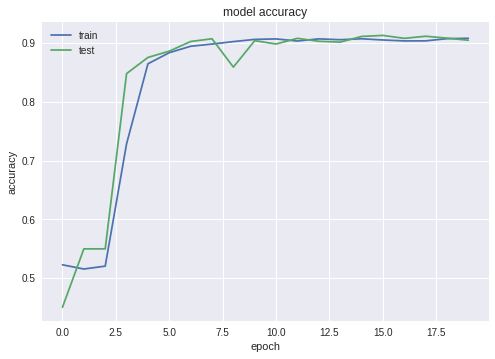

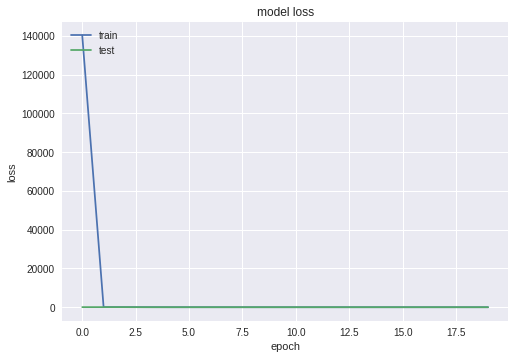

In [93]:
# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [94]:
X_test = np.load('/content/drive/My Drive/Updated_Data/Test_Processed_64.npy')
X_test = X_test/255
X_test -= mean
X_test /= std
print(X_test.shape)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1],X_test.shape[2],1)
model.save_weights('custom2_3_weights.h5')

(12815, 64, 64)


In [0]:
Y_predicted = model.predict(X_test)

In [96]:
print(Y_predicted.shape)
for i in range(0,Y_predicted.shape[0]):
    Y_predicted[i][0] = Y_predicted[i][0] / xscale
    Y_predicted[i][1] = Y_predicted[i][1] / xscale
    Y_predicted[i][2] = Y_predicted[i][2] / yscale
    Y_predicted[i][3] = Y_predicted[i][3] / yscale

(12815, 4)


In [97]:
X_label = np.load('/content/drive/My Drive/Updated_Data/X_test.npy')
X_label = X_label.reshape(X_label.shape[0],1)
print(X_label.shape)
for i in range(0,X_label.shape[0]):
  X_label[i] = X_label[i][0].split('/')[2]

print(X_label.shape)
print(X_label)
DF = np.concatenate((X_label, Y_predicted), axis=1)
print(DF.shape)
print(DF)
type(DF[0][2])

(12815, 1)
(12815, 1)
[['JPEG_20161129_130901_1000335000914.png']
 ['JPEG_20161209_201456_100034997460.png']
 ['14751585951781.png']
 ...
 ['JPEG_20160630_165248_1000513257867.png']
 ['1467548589518Odomos-Oil-Pack.png']
 ['1480334022239_R2A3610.png']]
(12815, 5)
[['JPEG_20161129_130901_1000335000914.png' '79.157455' '576.4541'
  '88.52753' '358.19342']
 ['JPEG_20161209_201456_100034997460.png' '104.045364' '521.3014'
  '65.82577' '430.21765']
 ['14751585951781.png' '126.87031' '531.9941' '71.67922' '385.35605']
 ...
 ['JPEG_20160630_165248_1000513257867.png' '177.20325' '392.7261'
  '89.622925' '319.88446']
 ['1467548589518Odomos-Oil-Pack.png' '47.584835' '592.707' '28.886402'
  '419.60776']
 ['1480334022239_R2A3610.png' '125.50745' '441.45416' '58.59164'
  '312.27655']]


numpy.str_

In [0]:
import pandas as pd
out = pd.DataFrame({'image_name':DF[:,0],'x1':DF[:,1],'x2':DF[:,2],'y1':DF[:,3],'y2':DF[:,4]})

In [99]:
print(out.shape)
out.to_csv('predictions3.csv')

(12815, 5)


In [100]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

uploaded = drive.CreateFile({'title': 'predictions3.csv'})
uploaded.SetContentFile('predictions3.csv')
uploaded.Upload()
print('Uploaded file with ID {}'.format(uploaded.get('id')))

uploaded = drive.CreateFile({'title': 'custom2_4_weights.h5'})
uploaded.SetContentFile('custom2_3_weights.h5')
uploaded.Upload()
print('Uploaded file with ID {}'.format(uploaded.get('id')))

Uploaded file with ID 15aaEmT2AB_jTn6rDB6yc6gzHoFzwTGH3
Uploaded file with ID 1Fk_512KpuyxXGEKNlVLgCYBxxMY0XEtR


In [49]:
!ls


adc.json  custom2_2_weights.h5	drive  predictions.csv	sample_data


Uploaded file with ID 1WASMezxve0OfczQQ_mu9E64Pa7EdzsBq
